# 加载预训练的VAE模型，并打印模型结构

In [1]:
from diffusers import AutoPipelineForText2Image
import torch

# 1. 加载预训练的VAE模型
device = "cuda:3" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

pipe = AutoPipelineForText2Image.from_pretrained("warp-ai/wuerstchen", local_files_only=True, torch_dtype=torch.float16).to(device)
pipe.enable_xformers_memory_efficient_attention()

# 2. 打印模型结构
print(pipe.config)

Using cuda:3


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

FrozenDict([('text_encoder', ('transformers', 'CLIPTextModel')), ('tokenizer', ('transformers', 'CLIPTokenizerFast')), ('decoder', ('wuerstchen', 'WuerstchenDiffNeXt')), ('scheduler', ('diffusers', 'DDPMWuerstchenScheduler')), ('vqgan', ('wuerstchen', 'PaellaVQModel')), ('prior_prior', ('wuerstchen', 'WuerstchenPrior')), ('prior_text_encoder', ('transformers', 'CLIPTextModel')), ('prior_tokenizer', ('transformers', 'CLIPTokenizerFast')), ('prior_scheduler', ('diffusers', 'DDPMWuerstchenScheduler')), ('_name_or_path', 'warp-ai/wuerstchen')])


# 从视频随机加载max_frames张图片

In [21]:
import cv2
from PIL import Image
import numpy as np
import random

# 1. 加载视频
video_path = "assets/girl.mp4"  # 替换为你的视频路径
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
    exit()

# 获取视频总帧数
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 计算起始帧，确保从这一帧开始有足够的帧数可以读取
max_frames = 10  # 我们想要读取的帧数
if total_frames > max_frames:
    random_frame = random.randint(0, total_frames - max_frames)  # 保证有足够的帧可以读取
else:
    random_frame = 0  # 如果视频帧数不足max_frames，则从头开始

# 设置视频的当前位置
cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)

input_images = []  # 用于存储图像对象的列表
frame_count = 0

while frame_count < max_frames:
    ret, frame = cap.read()
    if ret:
        # OpenCV读取的图像格式为BGR，转换为RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # 将NumPy数组转换为PIL.Image对象
        img = Image.fromarray(frame_rgb)
        input_images.append(img)
        frame_count += 1
    else:
        break

# 释放视频捕获对象
cap.release()

print(f"Read {len(input_images)} frames, starting from frame {random_frame}")


Read 10 frames, starting from frame 3828


# 显示加载的图片

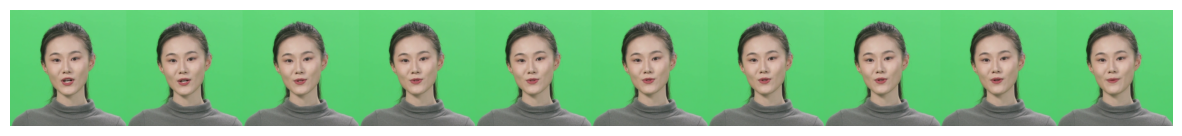

In [22]:
from PIL import Image
import matplotlib.pyplot as plt


# 2. 横向拼接图像
total_width = sum(img.width for img in input_images)
max_height = max(img.height for img in input_images)
concatenated_img = Image.new('RGB', (total_width, max_height))

x_offset = 0
for img in input_images:
    concatenated_img.paste(img, (x_offset,0))
    x_offset += img.width

# 3. 显示拼接的图像
plt.figure(figsize=(15, 5))  # 设置图像显示大小
plt.imshow(concatenated_img)
plt.axis('off')
plt.show()


# 图片预处理

In [23]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor

# 1. 图片预处理
image_size = 512

def preprocess(image, image_size):
    transform = Compose([
        Resize(image_size),
        CenterCrop(image_size),
        ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # 增加批次维度

input_tensor = torch.cat([preprocess(image, image_size) for image in input_images])
input_tensor = input_tensor.to(device).half()

# 2. 打印输入张量的形状
print(input_tensor.shape)
print(input_tensor.min(), input_tensor.max())

torch.Size([10, 3, 512, 512])
tensor(0.0353, device='cuda:3', dtype=torch.float16) tensor(0.8940, device='cuda:3', dtype=torch.float16)


# 用VAE编码，解码图片，并计算L1 loss

In [24]:
import torch

# 1. 编码与解码
with torch.no_grad():
    # 编码
    latents = pipe.vqgan.encode(input_tensor).latents
    
    # 打印潜在向量的形状
    print("Latents shape:", latents.shape)
        
    # 解码
    output_tensor = pipe.vqgan.decode(latents).sample
    
    # 打印输出张量的形状
    print("Output shape:", output_tensor.shape)
    print(output_tensor.min(), output_tensor.max())


# 2. 计算L1 Loss
l1_loss = torch.nn.functional.l1_loss(input_tensor, output_tensor)

print(f"L1 Loss: {l1_loss.item()}")

Latents shape: torch.Size([10, 4, 128, 128])
Output shape: torch.Size([10, 3, 512, 512])
tensor(0.0086, device='cuda:3', dtype=torch.float16) tensor(0.8799, device='cuda:3', dtype=torch.float16)
L1 Loss: 0.01169586181640625


# 创建并显示输出图片

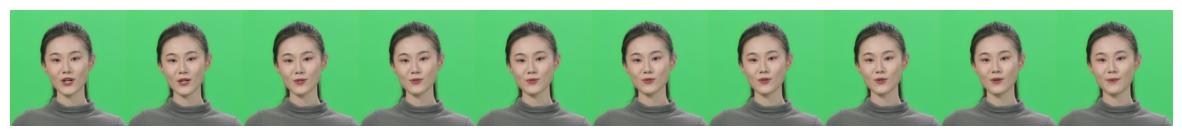

In [25]:
# 1. 创建输出图片

# 首先，将张量归一化到[0, 1]
clamped_output_tensor = output_tensor.clamp(0, 1)

# 将归一化的数据转换为图像
output_images = [(image_tensor.squeeze(0) * 255).permute(1, 2, 0).byte().cpu().numpy() for image_tensor in clamped_output_tensor]

# output_image = (output_tensor.squeeze(0).add(1).div(2).clamp(0, 1) * 255).permute(1, 2, 0).byte().cpu().numpy()
output_images = [Image.fromarray(output_image) for output_image in output_images]

# 2. 横向拼接图像
total_width = sum(img.width for img in output_images)
max_height = max(img.height for img in output_images)
concatenated_img = Image.new('RGB', (total_width, max_height))

x_offset = 0
for img in output_images:
    concatenated_img.paste(img, (x_offset,0))
    x_offset += img.width

# 3. 显示拼接的图像
plt.figure(figsize=(15, 5))  # 设置图像显示大小
plt.imshow(concatenated_img)
plt.axis('off')
plt.show()

# 对比输入图片和输出图片

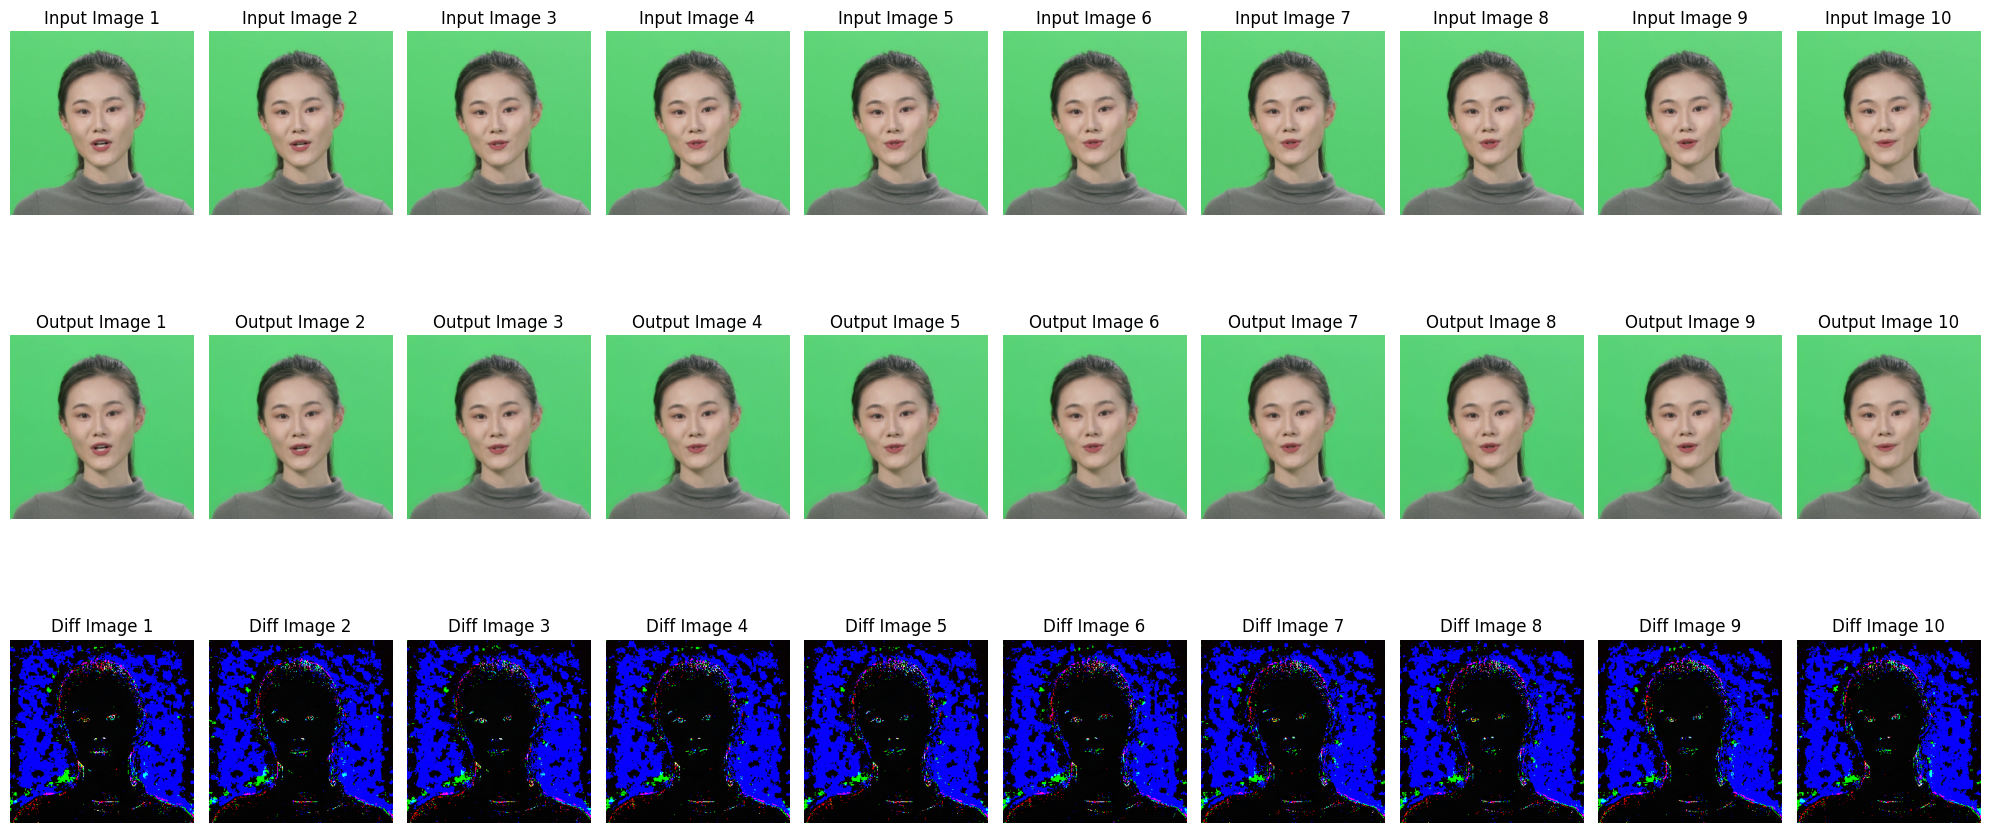

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# 确保 input_images 和 output_images 长度相同
assert len(input_images) == len(output_images), "Input and output image lists must have the same length."

# 计算需要的列数（每组图片需要3列）
num_columns = len(input_images)

# 计算需要的行数，这里每个图片对都会占用一行
num_rows = 3

# 创建一个大的画布
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

for i in range(len(input_images)):
    # 将当前的 input 和 output 图片缩放到 image_size
    input_image_resized = input_images[i].resize((image_size, image_size))
    output_image_resized = output_images[i].resize((image_size, image_size))
    
    # 将 PIL 图片对象转换为 NumPy 数组
    input_image_array = np.asarray(input_image_resized)
    output_image_array = np.asarray(output_image_resized)
    
    # 计算差异图片
    diff_image_array = np.abs(input_image_array - output_image_array)
    
    # 显示输入图片
    axes[0, i].imshow(input_image_array)
    axes[0, i].set_title(f"Input Image {i+1}")
    axes[0, i].axis("off")
    
    # 显示输出图片
    axes[1, i].imshow(output_image_array)
    axes[1, i].set_title(f"Output Image {i+1}")
    axes[1, i].axis("off")
    
    # 显示差异图片
    axes[2, i].imshow(diff_image_array)
    axes[2, i].set_title(f"Diff Image {i+1}")
    axes[2, i].axis("off")

# 调整布局
plt.tight_layout()
plt.show()


In [28]:
import cv2

# 假设 output_images 是已经加载的 PIL 图片对象的列表
# output_images = [...]

# 定义视频的参数
fps = 1  # 每秒帧数
video_size = (image_size, image_size)  # 视频中每帧的大小，确保与你的图像尺寸一致
video_filename = 'girl_out.mp4'  # 输出视频的文件名

# 初始化视频写入器
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 如果X264不工作，尝试其他编码器
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, video_size)

for img in output_images:
    # 将PIL图像转换为OpenCV图像格式
    img_cv = cv2.cvtColor(np.array(img.resize(video_size)), cv2.COLOR_RGB2BGR)
    
    # 写入帧到视频
    video_writer.write(img_cv)

# 释放资源
video_writer.release()

print(f"视频已保存为 {video_filename}")


视频已保存为 girl_out.mp4
